<a href="https://colab.research.google.com/github/jayjay-park/Dynamical-System/blob/main/regression_gde_2nd_revision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# If you have installed dgl-cuXX package, please uninstall it first.
!pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

In [ ]:
!pip install torchdiffeq

In [5]:
import math
import numpy as np
import scipy.sparse as sp
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

In [6]:
import dgl
import dgl.data
import networkx as nx

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# Helper Function

In [7]:
from typing import Callable
import dgl.function as fn

class GCNLayer(nn.Module):
    def __init__(self, g:dgl.DGLGraph, in_feats:int, out_feats:int, activation:Callable[[torch.Tensor], torch.Tensor],
                 dropout:int, bias:bool=True):
        super().__init__()
        self.g = g
        self.weight = nn.Parameter(torch.Tensor(in_feats, out_feats))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_feats))
        else:
            self.bias = None
        self.activation = activation
        if dropout:
            self.dropout = nn.Dropout(p=dropout)
        else:
            self.dropout = 0.
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, h):
        #initialize h
        if self.dropout:
            h = self.dropout(h)
        h = torch.mm(h, self.weight)

        # normalization by square root of src degree
        h = h * self.g.ndata['norm']
        self.g.ndata['h'] = h

        # message passing and aggregation 
        # copy_u(): 'm' is the output message field and 'h' is the source feature field
        self.g.update_all(fn.copy_u('h', 'm'),
                          fn.sum(msg='m', out='h'))
        h = self.g.ndata.pop('h')
        
        # normalization by square root of dst degree
        h = h * self.g.ndata['norm']
        
        # bias
        if self.bias is not None:
            h = h + self.bias
        if self.activation:
            h = self.activation(h)
        return h


class GCN(nn.Module):
    def __init__(self, num_layers:int, g:dgl.DGLGraph, in_feats:int, hidden_feats:int,
                 out_feats:int, activation:Callable, dropout:int, bias=True):
        super().__init__()
        self.layers = nn.ModuleList()

        self.layers.append(GCNLayer(g, in_feats, hidden_feats, activation, dropout))

        for i in range(num_layers - 2):
            self.layers.append(GCNLayer(g, hidden_feats, hidden_feats, activation, dropout))

        self.layers.append(GCNLayer(g, hidden_feats, out_feats, None, 0.))

    def set_graph(self, g):
        for l in self.layers:
            l.g = g

    def forward(self, features):
        h = features
        for layer in self.layers:
            h = layer(h)
        return h


In [8]:
class GDEFunc(nn.Module):
    def __init__(self, gnn:nn.Module):
        """General GDE function class. To be passed to an ODEBlock"""
        super().__init__()
        self.gnn = gnn
        self.nfe = 0
    
    def set_graph(self, g:dgl.DGLGraph):
        for layer in self.gnn:
            layer.g = g
            
    def forward(self, t, x):
        self.nfe += 1
        x = self.gnn(x)
        return x

    
class ControlledGDEFunc(GDEFunc):
    def __init__(self, gnn:nn.Module):
        """ Controlled GDE version. Input information is preserved longer via hooks to input node features X_0, 
            affecting all ODE function steps. Requires assignment of '.h0' before calling .forward"""
        super().__init__(gnn)
        self.nfe = 0
            
    def forward(self, t, x):
        self.nfe += 1
        x = torch.cat([x, self.h0], 1)
        x = self.gnn(x)
        return x

In [9]:
import torch.nn as nn
import torchdiffeq

class ODEBlock(nn.Module):
    def __init__(self, odefunc:nn.Module, method:str='dopri5', rtol:float=1e-3, atol:float=1e-4, adjoint:bool=True):
        """ Standard ODEBlock class. Can handle all types of ODE functions
            :method:str = {'euler', 'rk4', 'dopri5', 'adams'}
        """
        super().__init__()
        self.odefunc = odefunc
        self.method = method
        self.adjoint_flag = adjoint
        self.atol, self.rtol = atol, rtol

    def forward(self, x:torch.Tensor, T:int=1):
        self.integration_time = torch.tensor([0, T]).float()
        self.integration_time = self.integration_time.type_as(x)

        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, self.integration_time,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                     rtol=self.rtol, atol=self.atol, method=self.method)
            
        return out[-1]
    
    def forward_batched(self, x:torch.Tensor, nn:int, indices:list, timestamps:set):
        """ Modified forward for ODE batches with different integration times """
        timestamps = torch.Tensor(list(timestamps))
        if self.adjoint_flag:
            out = torchdiffeq.odeint_adjoint(self.odefunc, x, timestamps,
                                             rtol=self.rtol, atol=self.atol, method=self.method)
        else:
            out = torchdiffeq.odeint(self.odefunc, x, timestamps,
                                     rtol=self.rtol, atol=self.atol, method=self.method)

        out = self._build_batch(out, nn, indices).reshape(x.shape)
        return out
    
    def _build_batch(self, odeout, nn, indices):
        b_out = []
        for i in range(len(indices)):
            b_out.append(odeout[indices[i],i*nn:(i+1)*nn])
        return torch.cat(b_out).to(odeout.device)
              
        
    def trajectory(self, x:torch.Tensor, T:int, num_points:int):
        self.integration_time = torch.linspace(0, t_end, num_points)
        self.integration_time = self.integration_time.type_as(x)
        out = torchdiffeq.odeint(self.odefunc, x, self.integration_time,
                                 rtol=self.rtol, atol=self.atol, method=self.method)
        return out

In [10]:
class PerformanceContainer(object):
    """ Simple data class for metrics logging."""
    def __init__(self, data:dict):
        self.data = data
        
    @staticmethod
    def deep_update(x, y):
        for key in y.keys():
            x.update({key: list(x[key] + y[key])})
        return x

def accuracy(y_hat:torch.Tensor, y:torch.Tensor):
    """ Standard percentage accuracy computation """
    preds = torch.max(y_hat, 1)[1]
    return torch.mean((y == preds).float())

# Semi-supervised node regression 

## Data preparation

**Our Data** \\
`X dim: num_node x num_feats (=1)` \\
`Y dim: num_node x dim (=1)`

In [13]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import random

In [74]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# seed for repeatability
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.manual_seed(42)
np.random.seed(42)

In [12]:
def deriv(t, X, a, b):
    """Return the derivatives dx/dt and dy/dt."""
    x, y = X
    dxdt = a - (1+b)*x + x**2 * y
    dydt = b*x - x**2 * y
    return dxdt, dydt

In [14]:
# Generate data
# time iteration
ti, tf = 0, 271
t_eval = np.arange(0, 271, 1).tolist()

# initialize
a = 1
b = 2.02

In [15]:
# Integrate Brusselator eq for parameters a, b
# solve_ivp: integrates a system of ODE given an initial value
#            (ti, tf) = interval of integration
#            (x0, y0) = initial state
#            dense_output = whether to compute a continuous solution 

# Step 2: Calculate ode for each interaction

ode = solve_ivp(deriv, (ti, tf), (1, 1), dense_output = True, args=(a,b), t_eval = t_eval)
sol = ode.y
print(len(sol[0]))

271


In [16]:
sol[0][99], sol[1][99]

(1.125833949453845, 2.041324461093472)

In [ ]:
# Step 3: Create one graph instance 
#trajectory = [] # len is timestamp, which is in this case, 1500

entire_rate = []
entire_y = []
n_train = 120
n_test = 50
n_nodes = 2

u = torch.tensor([0])
v = torch.tensor([1])

# for each time stamp,
# 100 graphs with 2 nodes, and node features are dim 1.
g = dgl.graph((u, v), num_nodes=2)
g.ndata["feat"] = torch.tensor([sol[0][99], sol[1][99]])
g.ndata["label"] = torch.tensor([sol[0][100], sol[1][100]])

'''Create Training Dataset'''
X = np.zeros((n_train,n_nodes))
Y = np.zeros((n_train, n_nodes))

for i in range(n_train):
  X[i][0] = sol[0][100+i]
  X[i][1] = sol[1][100+i]
  Y[i][0] = sol[0][101+i]
  Y[i][1] = sol[1][101+i]

X = torch.tensor(X).reshape(120,2)
Y = torch.tensor(Y).reshape(120,2)

'''Create Test Dataset'''
X_test = np.zeros((n_test, n_nodes))
Y_test = np.zeros((n_test, n_nodes))

for i in range(n_test):
  X_test[i][0] = sol[0][220+i]
  X_test[i][1] = sol[1][220+i]
  Y_test[i][0] = sol[0][221+i]
  Y_test[i][1] = sol[1][221+i]

X_test = torch.tensor(X_test).reshape(50, 2)
Y_test = torch.tensor(Y_test).reshape(50, 2)

**Modification** \\

`Before change: num_edges = 1` \\
`After change: num_edges = 2` \\

DGL graph is directed graph when our graph instances are undirected graph. Therefore, graph from previous attempt only had one edge, which made node feature 'norm' 0 for one node and 1 for the other node. But due to normalization process in GCN layer, node with 'norm' = 0 will always have 0 for hidden representation. Therefore, added one more edge so that 'norm' will become [1,1] instead of [0,1]

In [18]:
#modification
g.add_edges(torch.tensor([1]), torch.tensor([0]))
g

Graph(num_nodes=2, num_edges=2,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.float64), 'label': Scheme(shape=(), dtype=torch.float64)}
      edata_schemes={})

In [19]:
X.shape, Y.shape, X_test.shape, Y_test.shape

(torch.Size([120, 2]),
 torch.Size([120, 2]),
 torch.Size([50, 2]),
 torch.Size([50, 2]))

In [20]:
# compute diagonal of normalization matrix D according to standard formula
degs = g.in_degrees().float()
norm = torch.pow(degs, -0.5)
norm[torch.isinf(norm)] = 0
# add to dgl.Graph in order for the norm to be accessible at training time
g.ndata['norm'] = norm.unsqueeze(1).to(device)

# Graph Neural Differential Equations (GDEs)

As Neural ODEs, GDEs require specification of an ODE function (`ODEFunc`), representing the set of layers that will be called repeatedly by the ODE solver, as well as an ODE block (`ODEBlock`), tasked with calling the ODE solver on the ODE function. The ODEFunc is passed to the ODEBlock at initialization.

We introduce the convolutional variant of GDEs, `GCDEs`. The only difference resides in the type of GNN layer utilized in the ODEFunc.

For adaptive step GDEs (dopri5) we increase the hidden dimension to 64 to reduce the stiffness of the ODE and therefore the number of ODEFunc evaluations (`NFE`: Number Function Evaluation)

In [40]:
torch.manual_seed(42)

# for GCDEs, the ODEFunc is specified by two GCN layers. Softplus is used as activation. Smoother activations
# have been observed to help avoid numerical instability and reduce stiffness of the ODE described
# by a repeated call to the ODEFunc. High dropout improves performance on transductive node classification
# tasks due to their small training sets. GDEs can take advantage of this property due to their 'deeper'
# computational graph. NOTE: too much dropout increases stiffness and therefore NFEs
num_feats=1

#64
gnn = nn.Sequential(GCNLayer(g=g, in_feats=1, out_feats=1, activation=nn.Softplus(), dropout=0.),
                  GCNLayer(g=g, in_feats=1, out_feats=1, activation=None, dropout=0.)
                 ).to(device)

gdefunc = GDEFunc(gnn)

# dopri5 is an adaptive step solver and will call `gdefunc` several times to ensure correctness up to pre-specified 
# tolerance levels. rk4 will call the func 4 times. As suggested in the original Neural ODE paper and as observed during internal tests, lower tolerances 
# are sufficient for classification tasks. 
gde = ODEBlock(odefunc=gdefunc, method='rk4', atol=1e-3, rtol=1e-4, adjoint=False).to(device)


m = nn.Sequential(GCNLayer(g=g, in_feats=num_feats, out_feats=1, activation=F.relu, dropout=0.),
                  gde,
                  GCNLayer(g=g, in_feats=1, out_feats=num_feats, activation=None, dropout=0.)
                  ).to(device)

### Training loop

In our current GDE model, ODEFunc is evaluated 480 times, it is considered as deep model rather than shallow network model.


**Modification** \\
`Before change: single for loop` \\
`After change: double for loop to iterate over one graph instance at a time` \\

This change is based on GDE paper, section 4.2 Multi–Agent Trajectory Extrapolation. On experiment setup, authors note that "all models are optimized to minimize mean–squared–error (MSE) of 1–step predictions using Adam (Kingma and Ba, 2014) with constant learning rate 0.01." 



In [41]:
# Dataloader
train_data = torch.utils.data.TensorDataset(X, Y)
test_data = torch.utils.data.TensorDataset(X_test, Y_test)

# Data iterables
train_iter = torch.utils.data.DataLoader(train_data, batch_size=1)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=1)

In [42]:
# initial parameter
for param in m.named_parameters():
  print(param)

('0.weight', Parameter containing:
tensor([[-0.2191]], requires_grad=True))
('0.bias', Parameter containing:
tensor([0.2018], requires_grad=True))
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[0.7645]], requires_grad=True))
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([0.8300], requires_grad=True))
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[-0.2343]], requires_grad=True))
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([0.9186], requires_grad=True))
('2.weight', Parameter containing:
tensor([[-0.4869]], requires_grad=True))
('2.bias', Parameter containing:
tensor([0.5873], requires_grad=True))


**intial runtime's initial parameter values** \\
('0.weight', Parameter containing:
tensor([[-0.3852]], requires_grad=True))
('0.bias', Parameter containing:
tensor([0.2682], requires_grad=True))
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[-0.0075]], requires_grad=True))
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([0.5364], requires_grad=True))
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[-0.8230]], requires_grad=True))
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([-0.7359], requires_grad=True))
('2.weight', Parameter containing:
tensor([[-0.0198]], requires_grad=True))
('2.bias', Parameter containing:
tensor([0.7929], requires_grad=True))

**same runtime** \\
('0.weight', Parameter containing:
tensor([[0.4306]], requires_grad=True))
('0.bias', Parameter containing:
tensor([-0.4211], requires_grad=True))
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[-0.5822]], requires_grad=True))
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([-0.1695], requires_grad=True))
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[0.8518]], requires_grad=True))
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([0.4933], requires_grad=True))
('2.weight', Parameter containing:
tensor([[-0.3867]], requires_grad=True))
('2.bias', Parameter containing:
tensor([0.2294], requires_grad=True))

**This one worked well** \\
('0.weight', Parameter containing:
tensor([[-0.2191]], requires_grad=True))
('0.bias', Parameter containing:
tensor([0.2018], requires_grad=True))
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[0.7645]], requires_grad=True))
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([0.8300], requires_grad=True))
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[-0.2343]], requires_grad=True))
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([0.9186], requires_grad=True))
('2.weight', Parameter containing:
tensor([[-0.4869]], requires_grad=True))
('2.bias', Parameter containing:
tensor([0.5873], requires_grad=True)) \\

('0.weight', Parameter containing:
tensor([[-0.2191]], requires_grad=True))
('0.bias', Parameter containing:
tensor([0.2018], requires_grad=True))
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[0.7645]], requires_grad=True))
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([0.8300], requires_grad=True))
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[-0.2343]], requires_grad=True))
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([0.9186], requires_grad=True))
('2.weight', Parameter containing:
tensor([[-0.4869]], requires_grad=True))
('2.bias', Parameter containing:
tensor([0.5873], requires_grad=True))

In [43]:
opt = torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = torch.nn.MSELoss()
logger = PerformanceContainer(data={'train_loss':[], 'train_accuracy':[],
                                   'test_loss':[], 'test_accuracy':[],
                                   'forward_time':[], 'backward_time':[],
                                   'nfe': []})
steps = 50
verbose_step = 100
num_grad_steps = 0

pred_test = []
true_test = []
pred_all_iter = []
true_all_iter = []

for i in range(steps): # looping over epochs
  train_loss_sum = 0.0
  m.train()
  m.double()

  for x,y in train_iter:

    start_time = time.time()
    y_pred = m(x.T)

    f_time = time.time() - start_time
    nfe = m._modules['1'].odefunc.nfe
    
    loss = criterion(y_pred, y.T)
    train_loss_sum += loss.item()
    
    opt.zero_grad()
    start_time = time.time()
    loss.backward()
    b_time = time.time() - start_time
    opt.step()

    num_grad_steps += 1


  with torch.no_grad():
    m.eval()
    test_loss_sum = 0.0

    for x,y in test_iter:
      # calculating outputs again with zeroed dropout
      y_pred_test = m(x.T)
      m._modules['1'].odefunc.nfe = 0

      # save predicted node feature for analysis
      pred_test.append(y_pred_test.detach().numpy())
      true_test.append(y.T.detach().numpy())
      
      test_loss = criterion(y_pred_test, y.T).item()
      test_loss_sum += test_loss
    
  pred_all_iter.append(pred_test)
  true_all_iter.append(true_test)
  pred_test = []
  true_test = []
  
  print('[{}], Train Loss: {:3.3f}, Test Loss: {:3.3f}, NFE: {}'.format(num_grad_steps, train_loss_sum, test_loss_sum, nfe))

  logger.deep_update(logger.data, dict(train_loss=[train_loss_sum],
                  test_loss=[test_loss_sum], nfe=[nfe], forward_time=[f_time],
                  backward_time=[b_time]))

[120], Train Loss: 171.984, Test Loss: 58.471, NFE: 480
[240], Train Loss: 119.375, Test Loss: 42.631, NFE: 480
[360], Train Loss: 89.451, Test Loss: 32.725, NFE: 480
[480], Train Loss: 69.241, Test Loss: 25.473, NFE: 480
[600], Train Loss: 53.891, Test Loss: 19.895, NFE: 480
[720], Train Loss: 42.769, Test Loss: 16.296, NFE: 480
[840], Train Loss: 36.802, Test Loss: 14.842, NFE: 480
[960], Train Loss: 34.957, Test Loss: 14.548, NFE: 480
[1080], Train Loss: 34.669, Test Loss: 14.517, NFE: 480
[1200], Train Loss: 34.645, Test Loss: 14.515, NFE: 480
[1320], Train Loss: 34.644, Test Loss: 14.515, NFE: 480
[1440], Train Loss: 34.644, Test Loss: 14.515, NFE: 480
[1560], Train Loss: 34.644, Test Loss: 14.515, NFE: 480
[1680], Train Loss: 34.645, Test Loss: 14.515, NFE: 480
[1800], Train Loss: 34.645, Test Loss: 14.515, NFE: 480
[1920], Train Loss: 34.645, Test Loss: 14.515, NFE: 480
[2040], Train Loss: 34.645, Test Loss: 14.515, NFE: 480
[2160], Train Loss: 34.645, Test Loss: 14.515, NFE: 48

**first initialization**
('0.weight', Parameter containing:
tensor([[-0.2725]], dtype=torch.float64, requires_grad=True))
('0.bias', Parameter containing:
tensor([0.1591], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[-0.1587]], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([0.6837], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[-0.9689]], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([-0.8786], dtype=torch.float64, requires_grad=True))
('2.weight', Parameter containing:
tensor([[-0.1315]], dtype=torch.float64, requires_grad=True))
('2.bias', Parameter containing:
tensor([0.8990], dtype=torch.float64, requires_grad=True))
[120], Train Loss: 68.148, Test Loss: 20.388, NFE: 480

In [73]:
print("Final Model:")
print("Mean Squared Error of Training: ", 3.026/120)
print("Mean Squared Error of Test: ", 1.275/50)

Final Model:
Mean Squared Error of Training:  0.025216666666666665
Mean Squared Error of Test:  0.0255


In [25]:
print(m)

Sequential(
  (0): GCNLayer()
  (1): ODEBlock(
    (odefunc): GDEFunc(
      (gnn): Sequential(
        (0): GCNLayer(
          (activation): Softplus(beta=1, threshold=20)
        )
        (1): GCNLayer()
      )
    )
  )
  (2): GCNLayer()
)


In [44]:
# final model parameter
for param in m.named_parameters():
  print(param)

('0.weight', Parameter containing:
tensor([[-0.5854]], dtype=torch.float64, requires_grad=True))
('0.bias', Parameter containing:
tensor([1.2052], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[-0.8121]], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([1.4237], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[-0.7425]], dtype=torch.float64, requires_grad=True))
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([0.4956], dtype=torch.float64, requires_grad=True))
('2.weight', Parameter containing:
tensor([[-1.0975]], dtype=torch.float64, requires_grad=True))
('2.bias', Parameter containing:
tensor([1.0936], dtype=torch.float64, requires_grad=True))


**result after new runtime** \\
('0.weight', Parameter containing:
tensor([[-8.6485e-06]], dtype=torch.float64, requires_grad=True)) \\
('0.bias', Parameter containing:
tensor([1.5334e-38], dtype=torch.float64, requires_grad=True)) \\
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[-0.2934]], dtype=torch.float64, requires_grad=True)) \\
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([0.7045], dtype=torch.float64, requires_grad=True)) \\
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[-1.0183]], dtype=torch.float64, requires_grad=True)) \\
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([-0.8880], dtype=torch.float64, requires_grad=True)) \\
('2.weight', Parameter containing:
tensor([[-0.2432]], dtype=torch.float64, requires_grad=True)) \\
('2.bias', Parameter containing:
tensor([0.9642], dtype=torch.float64, requires_grad=True)) \\

Got stuck at test MSE of 14


**same runtime, new m instantiation** \\
('0.weight', Parameter containing:
tensor([[0.1694]], dtype=torch.float64, requires_grad=True)) \\
('0.bias', Parameter containing:
tensor([-0.4419], dtype=torch.float64, requires_grad=True)) \\
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[-0.0007]], dtype=torch.float64, requires_grad=True)) \\
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([1.0327], dtype=torch.float64, requires_grad=True)) \\
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[-1.0205]], dtype=torch.float64, requires_grad=True)) \\
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([-0.5498], dtype=torch.float64, requires_grad=True)) \\
('2.weight', Parameter containing:
tensor([[-0.7493]], dtype=torch.float64, requires_grad=True)) \\
('2.bias', Parameter containing:
tensor([0.0757], dtype=torch.float64, requires_grad=True)) \\

Got stuck at test MSE of 14

**same runtime, 2nd new m instantiation** \\
('0.weight', Parameter containing:
tensor([[0.1694]], dtype=torch.float64, requires_grad=True)) \\
('0.bias', Parameter containing:
tensor([-0.4419], dtype=torch.float64, requires_grad=True)) \\
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[-0.0007]], dtype=torch.float64, requires_grad=True)) \\
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([1.0327], dtype=torch.float64, requires_grad=True)) \\
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[-1.0205]], dtype=torch.float64, requires_grad=True)) \\
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([-0.5498], dtype=torch.float64, requires_grad=True)) \\
('2.weight', Parameter containing:
tensor([[-0.7493]], dtype=torch.float64, requires_grad=True)) \\
('2.bias', Parameter containing:
tensor([0.0757], dtype=torch.float64, requires_grad=True)) \\

test MSE of 1.391

**same runtime, 3rd new m instantiation, but also ran graph creation cell again** \\
('0.weight', Parameter containing: 
tensor([[0.8483]], dtype=torch.float64, requires_grad=True)) \\
('0.bias', Parameter containing:
tensor([-0.7232], dtype=torch.float64, requires_grad=True)) \\
('1.odefunc.gnn.0.weight', Parameter containing:
tensor([[1.5527]], dtype=torch.float64, requires_grad=True)) \\
('1.odefunc.gnn.0.bias', Parameter containing:
tensor([0.6307], dtype=torch.float64, requires_grad=True)) \\
('1.odefunc.gnn.1.weight', Parameter containing:
tensor([[0.3777]], dtype=torch.float64, requires_grad=True)) \\
('1.odefunc.gnn.1.bias', Parameter containing:
tensor([0.7118], dtype=torch.float64, requires_grad=True)) \\
('2.weight', Parameter containing:
tensor([[0.6572]], dtype=torch.float64, requires_grad=True)) \\
('2.bias', Parameter containing:
tensor([-0.0387], dtype=torch.float64, requires_grad=True)) \\

At first it seemed like it was stuck at 14, but decreased to 1.395

In [27]:
for mod in m.named_modules():
  print(mod)

('', Sequential(
  (0): GCNLayer()
  (1): ODEBlock(
    (odefunc): GDEFunc(
      (gnn): Sequential(
        (0): GCNLayer(
          (activation): Softplus(beta=1, threshold=20)
        )
        (1): GCNLayer()
      )
    )
  )
  (2): GCNLayer()
))
('0', GCNLayer())
('1', ODEBlock(
  (odefunc): GDEFunc(
    (gnn): Sequential(
      (0): GCNLayer(
        (activation): Softplus(beta=1, threshold=20)
      )
      (1): GCNLayer()
    )
  )
))
('1.odefunc', GDEFunc(
  (gnn): Sequential(
    (0): GCNLayer(
      (activation): Softplus(beta=1, threshold=20)
    )
    (1): GCNLayer()
  )
))
('1.odefunc.gnn', Sequential(
  (0): GCNLayer(
    (activation): Softplus(beta=1, threshold=20)
  )
  (1): GCNLayer()
))
('1.odefunc.gnn.0', GCNLayer(
  (activation): Softplus(beta=1, threshold=20)
))
('1.odefunc.gnn.0.activation', Softplus(beta=1, threshold=20))
('1.odefunc.gnn.1', GCNLayer())
('2', GCNLayer())


In [63]:
pred_all_iter = np.array(pred_all_iter)
true_all_iter = np.array(true_all_iter)

In [68]:
# pred_all_iter's dimension: num_of_iteration x num_of_test_dataset x num_of_node

pred_all_iter = pred_all_iter.reshape(50, 50, 2)
pred_mid = pred_all_iter[24]
pred_last = pred_all_iter[49]
print(pred_last[:, 0])

true_all_iter = true_all_iter.reshape(50, 50, 2)
true_mid = true_all_iter[24]
true_last = true_all_iter[49]

[1.04137137 0.8895683  0.85401157 0.93339099 1.11623913 1.23017775
 1.1022245  0.91621508 0.84755566 0.89941136 1.06436604 1.22926856
 1.14748935 0.95624036 0.85943927 0.87990196 1.01115837 1.19808531
 1.19677471 1.01917137 0.8596298  0.84519587 0.95200379 1.16479186
 1.24543005 1.07434972 0.87992221 0.83024819 0.90661419 1.10624265
 1.26410262 1.1206257  0.90399716 0.83216069 0.89082683 1.07292223
 1.25476838 1.15249658 0.94359872 0.84617676 0.87213058 1.01509934
 1.21939053 1.20876068 1.00124739 0.85050482 0.84437426 0.96026146
 1.18024611 1.24171161]


Text(0.5, 1.0, 'chemical substance type B prediction at last iter')

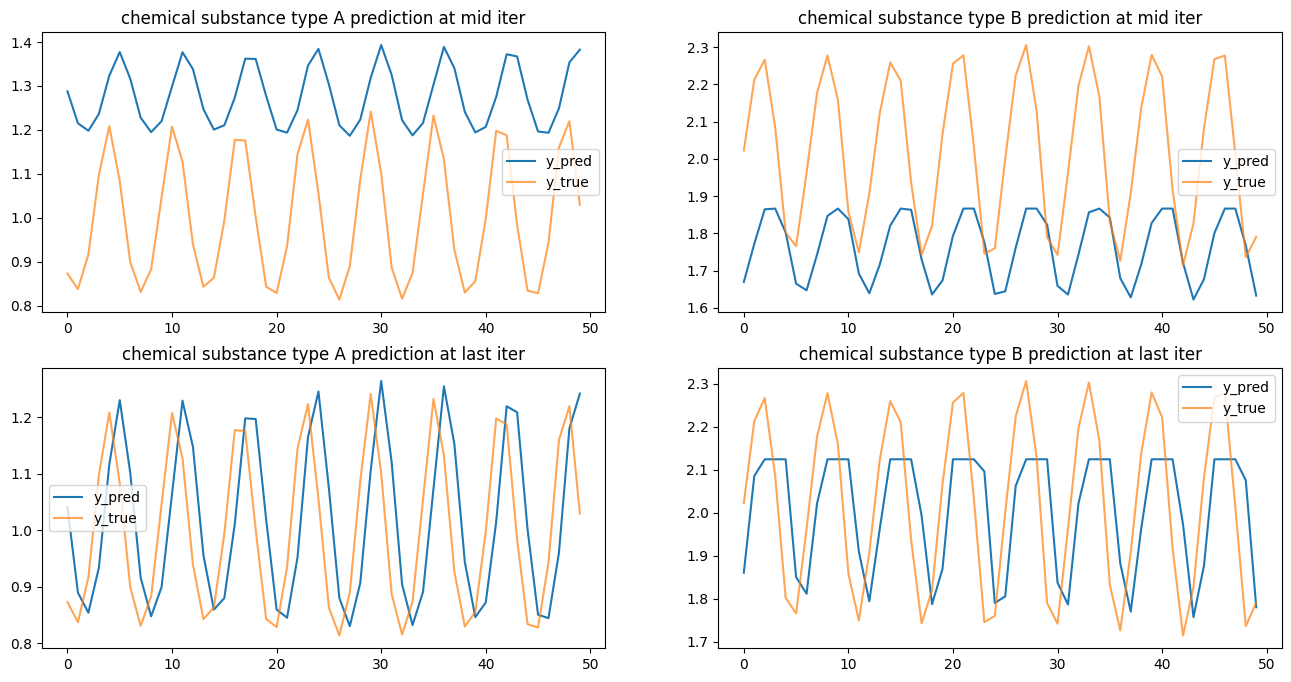

In [69]:
plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
plt.plot(pred_mid[:, 0])
plt.plot(true_mid[:, 0], alpha=0.7)
plt.legend(['y_pred', 'y_true'])
plt.title('chemical substance type A prediction at mid iter')

plt.subplot(2,2,2)
plt.plot(pred_mid[:, 1])
plt.plot(true_mid[:, 1], alpha=0.7)
plt.legend(['y_pred', 'y_true'])
plt.title('chemical substance type B prediction at mid iter')

plt.subplot(2,2,3)
plt.plot(pred_last[:, 0])
plt.plot(true_last[:, 0], alpha=0.7)
plt.legend(['y_pred', 'y_true'])
plt.title('chemical substance type A prediction at last iter')

plt.subplot(2,2,4)
plt.plot(pred_last[:, 1])
plt.plot(true_last[:, 1], alpha=0.7)
plt.legend(['y_pred', 'y_true'])
plt.title('chemical substance type B prediction at last iter')

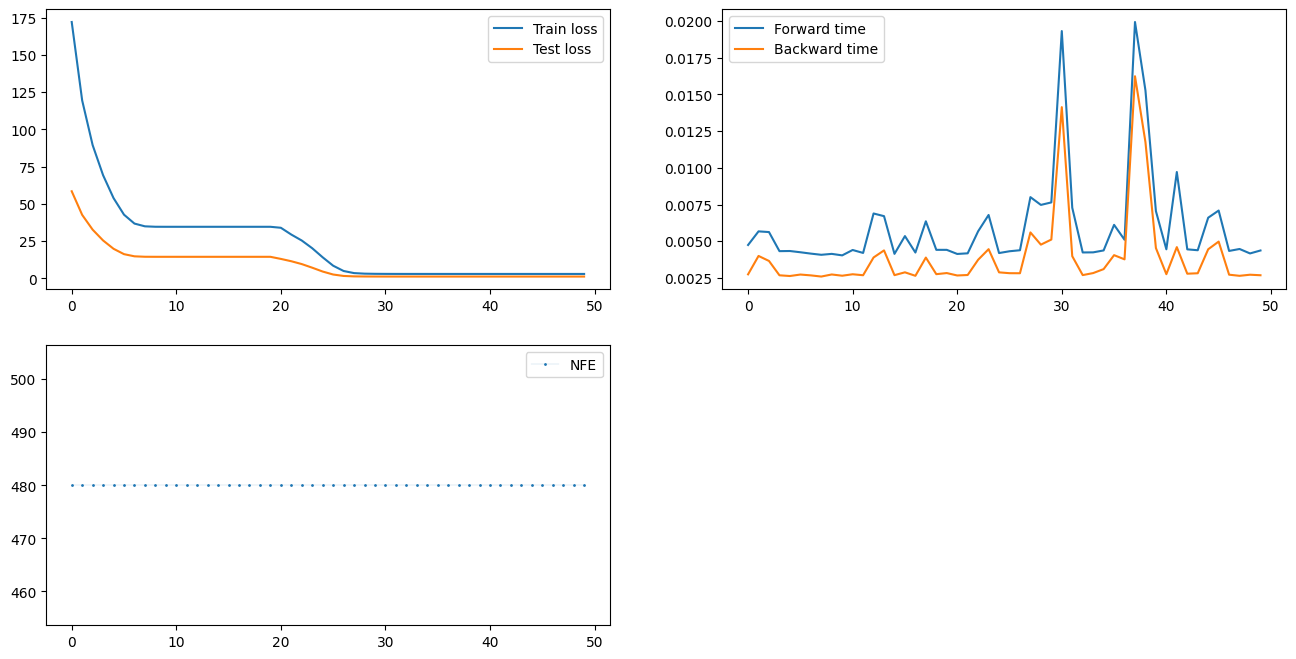

In [71]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(logger.data['train_loss'])
plt.plot(logger.data['test_loss'])
plt.legend(['Train loss', 'Test loss'])
# plt.subplot(2,2,2)
# plt.plot(logger.data['train_accuracy'])
# plt.plot(logger.data['test_accuracy'])
# plt.legend(['Train accuracy', 'Test accuracy'])
plt.subplot(2,2,2)
plt.plot(logger.data['forward_time'])
plt.plot(logger.data['backward_time'])
plt.legend(['Forward time', 'Backward time'])
plt.subplot(2,2,3)
plt.plot(logger.data['nfe'], marker='o', linewidth=0.1, markersize=1)
plt.legend(['NFE']);

## GCN

We are interested in observing the training behavior of regular GCNs of different layer depths. Below is a training loop
that will collect metrics for GCNs of layers `1, 3, 5, 7`

In [ ]:
loggers = []

for n_layers in range(2, 9, 2):
    
    gcn = GCN(num_layers=n_layers, g=g, in_feats=1, hidden_feats=64, out_feats=1, activation=F.relu, dropout=0.9).to(device)
    opt = torch.optim.Adam(gcn.parameters(), lr=1e-3, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    num_grad_steps = 3000
    
    gcn_logger = PerformanceContainer(data={'train_loss':[], 'train_accuracy':[],
                                    'test_loss':[], 'test_accuracy':[],
                                    'forward_time':[], 'backward_time':[]}
                                      )
    
    for i in range(num_grad_steps): # looping over epochs  
        start_time = time.time()
        outputs = gcn(X)
        f_time = time.time() - start_time

        y_pred = outputs

        loss = criterion(y_pred[train_mask], Y[train_mask])
        opt.zero_grad()

        start_time = time.time()
        loss.backward()
        b_time = time.time() - start_time
    
        opt.step()
        num_grad_steps += 1

        with torch.no_grad():
            gcn.eval()
            outputs = gcn(X)
            y_pred = outputs
            
            train_loss = loss.item()
            train_acc = accuracy(y_pred[train_mask], Y[train_mask]).item()
            test_acc = accuracy(y_pred[test_mask], Y[test_mask]).item()
            test_loss = criterion(y_pred[test_mask], Y[test_mask]).item()

            gcn_logger.deep_update(gcn_logger.data, dict(train_loss=[train_loss], train_accuracy=[train_acc],
                                   test_loss=[test_loss], test_accuracy=[test_acc], forward_time=[f_time],
                                   backward_time=[b_time]))
            
    loggers.append((gcn_logger, n_layers))

## Comparison plots

GCDEs are shown to be as performing as GDEs, while being deeper and not requiring selection of number of layers. They are observed to converge faster; the high degree of noise present is due to the aggressive dropout setting, used to exploit the increased depth of GCDEs.

In [ ]:
mean_nfe = int(np.array(logger.data['nfe']).mean())
layer_range = range(2, 9, 2)

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(logger.data['train_loss'])
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['train_loss'])
plt.title('Training loss')
plt.legend([f'GCDE{mean_nfe}'] + [f'GCN{i}' for i in layer_range])
plt.ylim(0,2)

plt.subplot(2,2,2)
plt.plot(logger.data['test_loss'])
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['test_loss'])
plt.title('Test loss')
plt.legend([f'GCDE{mean_nfe}'] + [f'GCN{i}' for i in layer_range])
plt.ylim(0,3)

plt.subplot(2,2,3)
plt.plot(logger.data['train_accuracy'])
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['train_accuracy'])
plt.title('Train accuracy')
plt.legend([f'GCDE{mean_nfe}'] + [f'GCN{i}' for i in layer_range])

plt.subplot(2,2,4)
plt.plot(logger.data['test_accuracy'])
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['test_accuracy'])
plt.title('Test accuracy')
plt.legend([f'GCDE{mean_nfe}'] + [f'GCN{i}' for i in layer_range]);

### Time complexity

The plots below show how forward time for GCDEs is roughly 6 times that of GCN2

In [ ]:
ftime = logger.data['forward_time']
btime = logger.data['backward_time']

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(ftime)
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['forward_time'])
plt.title('Forward time (s)')
plt.legend(['GCDE'] + [f'GCN{i}' for i in layer_range])
plt.ylim(0, 0.006)

plt.subplot(1,2,2)
plt.plot(btime)
for logger_gcn, l in loggers: plt.plot(logger_gcn.data['backward_time'])
plt.title('Backward time (s)')
plt.legend(['GCDE'] + [f'GCN{i}' for i in layer_range]);